# Chapter 6: Write

## Question-Answer Generator

The goal of this notebook is to create a model which can generate question and answer pairs about a block of text. This project is based on the [`qgen-workshop` TensorFlow codebase](https://github.com/Maluuba/qgen-workshop). The model consists of two components:

- An RNN which identifies possible question answers from a block of text.

- An encoder-decoder network that generates possible questions that the answers identified by the former model could be for.

An _encoder-decoder_ network is a type of RNN that outputs a new sequence from its input. Some applications of encoder-decoder networks include machine translation, question generation, and text summarization. An encoder-decoder model trains an encoder RNN to encode the input sequence into a vector input for the decoder RNN which outputs a novel sequence from the vector input.

## Question-Answer Dataset

### Step 1: Downloading the data from the Maluuba News QA repository

Below we download and preprocess the data for the model. The data we are using for this notebook is provided by the [Maluuba News QA GitHub repository](https://github.com/Maluuba/newsqa). We use the manual setup instructions with the relevant code below:

In [0]:
# Mount drive.

from google.colab import drive

drive.mount('/content/gdrive/')
base_dir = '/content/gdrive/My Drive/gdl_models/qa/'

In [0]:
!git clone https://github.com/Maluuba/newsqa

For legal reasons, you have to download the data yourself on [Microsoft's website](https://msropendata.com/datasets/939b1042-6402-4697-9c15-7a28de7e1321) and state what you are using the data for. To save myself the trouble of having to reupload the data each time we get a new Colab kernel, 

In [0]:
import os
import subprocess

def load_or_copy(filename):
  """Load a file from Drive or copy it locally into Drive."""
  drive_path = base_dir + filename
  if os.path.isfile(drive_path):
    print('File exists in drive')
    subprocess.call(['cp', drive_path, '.'])
  else:
    print('File exists locally')
    subprocess.call(['cp', filename, drive_path])

In [0]:
load_or_copy('newsqa.tar.gz')

File exists in drive


In [0]:
!mv newsqa.tar.gz newsqa/maluuba/newsqa/newsqa.tar.gz

Now we also download the CNN stories we will use to train the model. You can download the stories [here](https://cs.nyu.edu/~kcho/DMQA/).

In [0]:
load_or_copy('cnn_stories.tgz')

File exists in drive


In [0]:
!mv cnn_stories.tgz newsqa/maluuba/newsqa/cnn_stories.tgz

Now we upload the Java dependencies:

In [0]:
!wget https://nlp.stanford.edu/software/stanford-postagger-2015-12-09.zip

In [0]:
load_or_copy('stanford-postagger-2015-12-09.zip')

File exists in drive


In [0]:
!cp -r stanford-postagger-2015-12-09.zip newsqa/maluuba/newsqa/

Now we run the data processing script in the repository. We run the repository's tests to make sure the data was processed correctly.

In [0]:
!cd newsqa && python2 maluuba/newsqa/data_generator.py

In [0]:
!cd newsqa && python2 -m unittest discover .

[INFO] 2020-05-04 00:25:51,936 - data_processing.py::__init__
Loading dataset from `/content/newsqa/maluuba/newsqa/newsqa-data-v1.csv`...
[INFO] 2020-05-04 00:25:51,936 - data_processing.py::load_combined
Loading data from `/content/newsqa/maluuba/newsqa/newsqa-data-v1.csv`...
[INFO] 2020-05-04 00:25:52,456 - data_processing.py::__init__
Loading stories from `/content/newsqa/maluuba/newsqa/cnn_stories.tgz`...
Getting story texts: 100% 12.7k/12.7k [00:12<00:00, 1.05k stories/s] 
Setting story texts: 100% 120k/120k [00:03<00:00, 37.0k questions/s] 
[INFO] 2020-05-04 00:26:07,792 - data_processing.py::__init__
Done loading dataset.
Checking for possible corruption: 100% 120k/120k [00:01<00:00, 103k questions/s]
.[INFO] 2020-05-04 00:26:09,045 - data_processing.py::dump
Packaging dataset to `/content/newsqa/combined-newsqa-data-v1.json`.
Building json: 100% 120k/120k [00:05<00:00, 21.7k questions/s] 
Checking for possible corruption: 100% 12.7k/12.7k [00:00<00:00, 18.7k stories/s]
Gatherin

Now let's save the data to Drive. Once the code below runs, we will have a copy of the data that'll persist through different Colab kernel sessions.

In [0]:
def upload_to_drive(filepath):
  """Copy a file to Drive."""
  drive_path = base_dir + filepath.split('/')[-1]
  subprocess.call(['cp', filepath, drive_path])

In [0]:
upload_to_drive('newsqa/split_data/train.csv')

In [0]:
upload_to_drive('newsqa/split_data/test.csv')

In [0]:
upload_to_drive('newsqa/split_data/dev.csv')

### Step 2: Download GloVe embeddings

We need to download a set of pretrained word embeddings that were created using the Stanford GloVe (Global Vectors) algorithm, an unsupervised learning algorithm that uses a large set of words.

You can run the code below to download the embeddings.

In [0]:
!mkdir -p glove && wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-05-07 02:55:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-05-07 02:56:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-05-07 02:56:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
import zipfile

with zipfile.ZipFile('glove.6B.zip', 'r') as z:
    z.extractall('glove')

I'll upload the 100-dimensional embeddings we'll be using for the model to Drive so I don't have to download the entire zip file again.

In [0]:
upload_to_drive('glove/glove.6B.100d.txt')

Now we are going to trim the embeddings down to only the relevant encodings for our training set are kept.

In [0]:
import csv
from collections import Counter


MAX_DOCUMENT_LENGTH = 200


def tokenize(words):
  """Transform a string of words into uniformly lower case tokens."""
  return [w.lower() for w in words.split(' ')]


def load_data(csv_path):
  """Load the data from the CSV files generated by the Maluuba News QA repository."""
  stories = {}
  with open(csv_path) as f:
    for i, row in enumerate(csv.reader(f)):
      if i == 0:  # Header row.
        continue

      doc_id = row[0]
      existing_stories = stories.setdefault(doc_id, [])

      doc_text = row[1]
      if existing_stories and doc_text == existing_stories[0]['document_text']:
        doc_words = existing_stories[0]['document_words']
      else:
        doc_words = tokenize(doc_text)[:MAX_DOCUMENT_LENGTH]

      q_text = row[2]
      q_words = tokenize(q_text)

      answer = row[3]
      ans_indices = []
      for chunk in answer.split(','):
        start, end = (int(idx) for idx in chunk.split(':'))
        if end < MAX_DOCUMENT_LENGTH:
          ans_indices.extend(range(start, end))
      ans_text = ' '.join(doc_words[i] for i in ans_indices)

      if ans_indices:
        existing_stories.append({
            'document_id': doc_id,
            'document_text': doc_text,
            'document_words': doc_words,
            'answer_text': ans_text,
            'answer_indices': ans_indices,
            'question_text': q_text,
            'question_words': q_words,
        })
  return stories


def trim_embeddings():
  """Trim the Stanford GloVe embeddings to the 10,000 most common words in the training set."""
  doc_counts = Counter()
  q_counts = Counter()

  for data in [load_data(base_dir + 'train.csv').values(),
               load_data(base_dir + 'test.csv').values()]:
    for stories in data:
      if stories:
        doc_counts.update(stories[0]['document_words'])
        for story in stories:
          q_counts.update(story['question_words'])
  
  keep = set()
  for word, _ in q_counts.most_common(5000):
    keep.add(word)
  for word, _ in doc_counts.most_common():
    if len(keep) >= 10000:
      break
    keep.add(word)

  with open(base_dir + 'glove.6B.100d.txt') as f:
    with open(base_dir + 'glove.6B.100d.trimmed.txt', 'w') as f2:
      for line in f:
        if line.split(' ')[0] in keep:
          f2.write(line)

In [0]:
trim_embeddings()

## Preprocessing the Data for the Model

Below is code that will prepare the training and test sets for the model.

In [0]:
END_WORD = '<END>'
PADDING_WORD = '<PAD>'
START_WORD = '<START>'
UNKNOWN_WORD = '<UNK>'
MAX_BATCH_SIZE = 128

In [0]:
word_to_idx = {}
idx_to_word = []

def add_word(word):
  """Add a word to the dictionary."""
  if word in word_to_idx:
    return word_to_idx[word]
  idx = len(idx_to_word)
  idx_to_word.append(word)
  word_to_idx[word] = idx
  return idx

In [0]:
END_TOKEN = add_word(END_WORD)
PADDING_TOKEN = add_word(PADDING_WORD)
START_TOKEN = add_word(START_WORD)
UNKNOWN_TOKEN = add_word(UNKNOWN_WORD)

In [0]:
import numpy as np

embeddings_path = base_dir + 'glove.6B.100d.trimmed.txt'

with open(embeddings_path) as f:
  line = f.readline()
  chunks = line.split(' ')
  dim = len(chunks) - 1
  f.seek(0)

  vocab_size = sum(1 for line in f)
  vocab_size += 4
  f.seek(0)

  glove = np.ndarray((vocab_size, dim), dtype=np.float32)

  for token in [START_TOKEN, END_TOKEN, UNKNOWN_TOKEN, PADDING_TOKEN]:
    glove[token] = np.random.normal(0, 0.02, dim)

  for line in f:
    chunks = line.split(' ')
    idx = add_word(chunks[0])
    glove[idx] = [float(chunk) for chunk in chunks[1:]]
    if len(word_to_idx) >= vocab_size:
      break

In [0]:
import random


def look_up_word(word):
  """Look up token for word."""
  return word_to_idx.get(word, UNKNOWN_TOKEN)


def look_up_token(idx):
  """Look up word for token."""
  return idx_to_word[idx]


def prepare_batch(batch):
  """Prepare a batch of data for training."""
  ids_to_indices = {}
  doc_ids = []
  doc_text = []
  doc_words = []
  ans_text = []
  ans_indices = []
  q_text = []
  q_input_words = []
  q_output_words = []
  for i, entry in enumerate(batch):
    ids_to_indices.setdefault(entry['document_id'], []).append(i)
    doc_ids.append(entry['document_id'])
    doc_text.append(entry['document_text'])
    doc_words.append(entry['document_words'])
    ans_text.append(entry['answer_text'])
    ans_indices.append(entry['answer_indices'])
    q_text.append(entry['question_text'])
    q_words = entry['question_words']
    q_input_words.append([START_WORD] + q_words)
    q_output_words.append(q_words + [END_WORD])

  batch_size = len(batch)
  max_doc_len = max((len(doc) for doc in doc_words), default=0)
  max_ans_len = max((len(ans) for ans in ans_indices), default=0)
  max_q_len = max((len(q) for q in q_input_words), default=0)

  doc_tokens = np.zeros((batch_size, max_doc_len), dtype=np.int32)
  doc_lens = np.zeros(batch_size, dtype=np.int32)
  ans_labels = np.zeros((batch_size, max_doc_len), dtype=np.int32)
  ans_masks = np.zeros((batch_size, max_ans_len, max_doc_len), dtype=np.int32)
  ans_lens = np.zeros(batch_size, dtype=np.int32)
  q_input_tokens = np.zeros((batch_size, max_q_len), dtype=np.int32)
  q_output_tokens = np.zeros((batch_size, max_q_len), dtype=np.int32)
  q_lens = np.zeros(batch_size, dtype=np.int32)

  for i in range(batch_size):
    for j, word in enumerate(doc_words[i]):
      doc_tokens[i,j] = look_up_word(word)
    doc_lens[i] = len(doc_words[i])

    for j, idx in enumerate(ans_indices[i]):
      for shared_i in ids_to_indices[batch[i]['document_id']]:
        ans_labels[shared_i, idx] = 1
      ans_masks[i, j, idx] = 1
    ans_lens[i] = len(ans_indices[i])

    for j, word in enumerate(q_input_words[i]):
      q_input_tokens[i, j] = look_up_word(word)
    for j, word in enumerate(q_output_words[i]):
      q_output_tokens[i, j] = look_up_word(word)
    q_lens[i] = len(q_input_words[i])

  return {
      'size': batch_size,
      'document_ids': doc_ids,
      'document_text': doc_text,
      'document_words': doc_words,
      'document_tokens': doc_tokens,
      'document_lengths': doc_lens,
      'answer_text': ans_text,
      'answer_indices': ans_indices,
      'answer_labels': ans_labels,
      'answer_masks': ans_masks,
      'question_text': q_text,
      'question_input_tokens': q_input_tokens,
      'question_output_tokens': q_output_tokens,
      'question_lengths': q_lens,
  }


def process_stories(stories):
  """Process the stories from one of the input CSV files."""
  batch = []
  vals = list(stories.values())
  random.shuffle(vals)
  for story in vals:
    if len(batch) + len(story) > MAX_BATCH_SIZE:
      yield prepare_batch(batch)
      batch = []
    batch.extend(story)
  if batch:
    yield prepare_batch(batch)


def training_data():
  """Get the training data."""
  return process_stories(load_data(base_dir + 'train.csv'))


def test_data():
  """Get the test data."""
  return process_stories(load_data(base_dir + 'test.csv'))

## Model Architecture

Below we will define the model which will generate questions and answers. We make use of Keras' `Bidirectional` cell. This has a recurrent layer store hidden state for processing sequences forwards and backwards.

Below in the first cell is the part of the model which predicts if words in the story is a part of an answer or not.

In [0]:
%tensorflow_version 1.x
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense

VOCAB_SIZE = glove.shape[0]
EMBEDDING_DIMS = glove.shape[1]

GRU_UNITS = 100
DOC_SIZE = None
ANSWER_SIZE = None
Q_SIZE = None

document_tokens = Input(shape=(DOC_SIZE,), name='document_tokens')

embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIMS,
                      weights=[glove], mask_zero=True, name='embedding')
document_emb = embedding(document_tokens)

answer_outputs = Bidirectional(GRU(GRU_UNITS, return_sequences=True),
                               name='answer_outputs')(document_emb)
answer_tags = Dense(2, activation='softmax', name='answer_tags')(answer_outputs)

The second part of the model is a encoder-decoder network that takes an answer and tries to generate a matching question.

In [0]:
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

encoder_input_mask = Input(shape=(ANSWER_SIZE, DOC_SIZE),
                           name='encoder_input_mask')
encoder_inputs = Lambda(lambda x: K.batch_dot(x[0], x[1]),
                        name='encoder_inputs')([encoder_input_mask,
                                                answer_outputs])
encoder_states = GRU(2 * GRU_UNITS, name='encoder_cell')(encoder_inputs)

decoder_inputs = Input(shape=(Q_SIZE,), name='decoder_inputs')
decoder_emb = embedding(decoder_inputs)
decoder_emb.trainable = False

decoder_cell = GRU(2 * GRU_UNITS, return_sequences=True, name='decoder_cell')
decoder_states = decoder_cell(decoder_emb, initial_state=[encoder_states])

decoder_projection = Dense(VOCAB_SIZE, name='decoder_projection',
                           activation='softmax', use_bias=False)
decoder_outputs = decoder_projection(decoder_states)

In [0]:
from tensorflow.keras.models import Model

total_model = Model([document_tokens, decoder_inputs, encoder_input_mask],
                    [answer_tags, decoder_outputs])
answer_model = Model(document_tokens, [answer_tags])
decoder_initial_state_model = Model([document_tokens, encoder_input_mask],
                                    [encoder_states])

In [13]:
total_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
document_tokens (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    998200      document_tokens[0][0]            
                                                                 decoder_inputs[0][0]             
__________________________________________________________________________________________________
answer_outputs (Bidirectional)  (None, None, 200)    120600      embedding[0][0]                  
__________________________________________________________________________________________________
encoder_input_mask (InputLayer) [(None, None, None)] 0                                        

### Inference

We can test performance of the model in two ways: first we feed a new document to the model and it identifies which tokens in the document are parts of answers. We can use the `answer_model` above for this task. The second is we feed the model answers and it generates matching questions. For the second task, we'll have to define a separate inference model.

In [0]:
decoder_inputs_dynamic = Input(shape=(1,), name='decoder_inputs_dynamic')
decoder_emb_dynamic = embedding(decoder_inputs_dynamic)
decoder_init_state_dynamic = Input(shape=(2 * GRU_UNITS,),
                                   name='decoder_init_state_dynamic')
decoder_states_dynamic = decoder_cell(decoder_emb_dynamic,
                                      initial_state=[
                                        decoder_init_state_dynamic])
decoder_outputs_dynamic = decoder_projection(decoder_states_dynamic)

question_model = Model([decoder_inputs_dynamic, decoder_init_state_dynamic],
                       [decoder_outputs_dynamic, decoder_states_dynamic])

## Training

First we compile the model for training.

In [0]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.001)
total_model.compile(
    optimizer=opt,
    loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
    loss_weights=[1, 1])

In [0]:
EPOCHS = 500
initial_epoch = 457
weights_dir = base_dir + 'weights/'

In [0]:
X_test = test_data()

if initial_epoch > 0:
  total_model.load_weights(
      weights_dir + 'weights_{}.hdf5'.format(initial_epoch))

for epoch in range(initial_epoch + 1, EPOCHS + 1):
  print('Epoch: ', epoch)
  for i, batch in enumerate(training_data()):
    test_batch = next(X_test, None)
    if test_batch is None:
      X_test = test_data()
      test_batch = next(X_test, None)

    train_loss = total_model.train_on_batch(
        [batch['document_tokens'], batch['question_input_tokens'],
         batch['answer_masks']],
        [np.expand_dims(batch['answer_labels'], axis=-1),
         np.expand_dims(batch['question_output_tokens'], axis=-1)])
    
    test_loss = total_model.test_on_batch(
        [test_batch['document_tokens'], test_batch['question_input_tokens'],
         test_batch['answer_masks']],
        [np.expand_dims(test_batch['answer_labels'], axis=-1),
         np.expand_dims(test_batch['question_output_tokens'], axis=-1)])
    
    print('Train loss: {} | Test loss: {}'.format(train_loss, test_loss))
  total_model.save_weights(weights_dir + 'weights_{}.hdf5'.format(epoch))

## Analyzing the Results

Below we will demonstrate how the model can be used to find words it thinks are answers to questions about the document.

In [0]:
def collapse_documents(batch):
  """Collapse the documents down to 200 tokens."""
  seen_ids = set()
  keep = []

  for i in range(batch['size']):
    id = batch['document_ids'][i]
    if id in seen_ids:
      continue
    seen_ids.add(id)
    keep.append(i)
  
  result = {}
  for k, v in batch.items():
    if k == 'size':
      result[k] = len(keep)
    elif isinstance(v, np.ndarray):
      result[k] = v[keep]
    else:
      result[k] = [v[i] for i in keep]
  return result

In [0]:
X_test = test_data()
batch = next(X_test)
batch = collapse_documents(batch)

Below we plot the probability that words in a document will be an answer to a question. We see the model is able to recognize the title of the movie and several actors as being highly probable answers.

Predicted Answer Probabilities


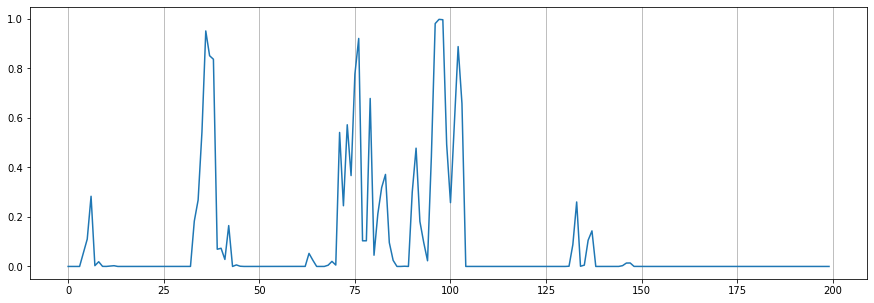

0 -lrb- 0.0
1 cnn 0.0
2 -rrb- 0.0
3 -- 0.0
4 smoking 0.05
5 is 0.11
6 bad 0.28
7 for 0.0
8 you 0.02
9 , 0.0
10 and 0.0
11 by 0.0
12 now 0.0
13 , 0.0
14 most 0.0
15 of 0.0
16 us 0.0
17 know 0.0
18 it 0.0
19 . 0.0
20 an 0.0
21 estimated 0.0
22 4.5 0.0
23 million 0.0
24 u.s. 0.0
25 adolescents 0.0
26 are 0.0
27 cigarette 0.0
28 smokers 0.0
29 . 0.0
30 it 0.0
31 seems 0.0
32 that 0.0
33 studies 0.18
34 on 0.27
35 the 0.54
36 dangers 0.95
37 of 0.85
38 smoking 0.84
39 come 0.07
40 out 0.07
41 every 0.03
42 week 0.17
43 . 0.0
44 just 0.01
45 recently 0.0
46 , 0.0
47 after 0.0
48 an 0.0
49 article 0.0
50 appeared 0.0
51 in 0.0
52 the 0.0
53 journal 0.0
54 pediatrics 0.0
55 , 0.0
56 we 0.0
57 were 0.0
58 introduced 0.0
59 to 0.0
60 the 0.0
61 concept 0.0
62 of 0.0
63 third-hand 0.05
64 smoke 0.03
65 , 0.0
66 the 0.0
67 potentially 0.0
68 toxic 0.0
69 residue 0.02
70 that 0.01
71 lingers 0.54
72 in 0.25
73 curtains 0.57
74 , 0.37
75 clothing 0.78
76 , 0.92
77 hair 0.1
78 , 0.1
79 etc. 0.68
80 a

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
idx = 0

total_model.load_weights(weights_dir + 'weights_500.hdf5')
answer_preds = answer_model.predict(batch['document_tokens'])

print('Predicted Answer Probabilities')
ax = plt.gca()
ax.xaxis.grid(True)
plt.plot(answer_preds[idx, :, 1])
plt.show()

for i, doc_words in enumerate(batch['document_words'][idx]):
    print(i, doc_words, np.round(answer_preds[idx][i][1],2))

In [0]:
def expand_answers(batch, answers):
  """Create a batch for the question generator based on the selected answer."""
  new_batch = []

  for i in range(batch['size']):
    split_answers = []
    last = None

    for j, tag in enumerate(answers):
      if not tag:
        continue
      if last != j - 1:
        split_answers.append([])
      split_answers[-1].append(j)
      last = j

    if len(split_answers) > 0:
      new_batch.append({
          'document_id': batch['document_ids'][i],
          'document_text': batch['document_text'][i],
          'document_words': batch['document_words'][i],
          'answer_text': ' '.join(batch['document_words'][i][j]
                                  for j in split_answers[0]),
          'answer_indices': split_answers[0],
          'question_text': '',
          'question_words': [],
      })
    else:
      new_batch.append({
          'document_id': batch['document_ids'][i],
          'document_text': batch['document_text'][i],
          'document_words': batch['document_words'][i],
          'answer_text': '',
          'answer_indices': [],
          'question_text': '',
          'question_words': [],
      })
  return prepare_batch(new_batch)

Below we will use the RNN to generate a question for the selected answer.

In [81]:
answer_start = 36
answer_end = 38

print('Answer:',
      ' '.join(batch['document_words'][idx][answer_start:answer_end + 1]))

answers = [0] * len(answer_preds[idx])
for i in range(answer_start, answer_end + 1):
  answers[i] = 1

answer_batch = expand_answers(batch, answers)
answer_batch

next_decoder_init_state = decoder_initial_state_model.predict(
    [answer_batch['document_tokens'][[idx]],
     answer_batch['answer_masks'][[idx]]])

word_tokens = [START_TOKEN]
question = [look_up_token(START_TOKEN)]

for i in range(21):
  word_preds, next_decoder_init_state = question_model.predict(
      [word_tokens, next_decoder_init_state])
  next_decoder_init_state = np.squeeze(next_decoder_init_state, axis=1)
  word_tokens = np.argmax(word_preds, 2)[0]
  question.append(look_up_token(word_tokens[0]))
  if word_tokens[0] == END_TOKEN:
    break

print('Question:', ' '.join(question))

Answer: dangers of smoking
Question: <START> what is widespread from american people ? <END>
